# IRAM Data Example

Trey V. Wenger (c) December 2024

Here we test `bayes_cn_hfs` on some real IRAM 30-m data and demonstrate a general procedure for determining the carbon isotopic ratio from observations of CN and 13CN.

In [1]:
# General imports   
import os
import pickle
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("pymc version:", pm.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import bayes_cn_hfs
print("bayes_cn_hfs version:", bayes_cn_hfs.__version__)

# Notebook configuration
pd.options.display.max_rows = None

pymc version: 5.19.1
bayes_spec version: 1.7.2
bayes_cn_hfs version: 1.0.2+2.g3f0e12d.dirty


## Load the data

12CN-1/2 650
12CN-3/2 551
13CN-1/2 550
13CN-3/2 550


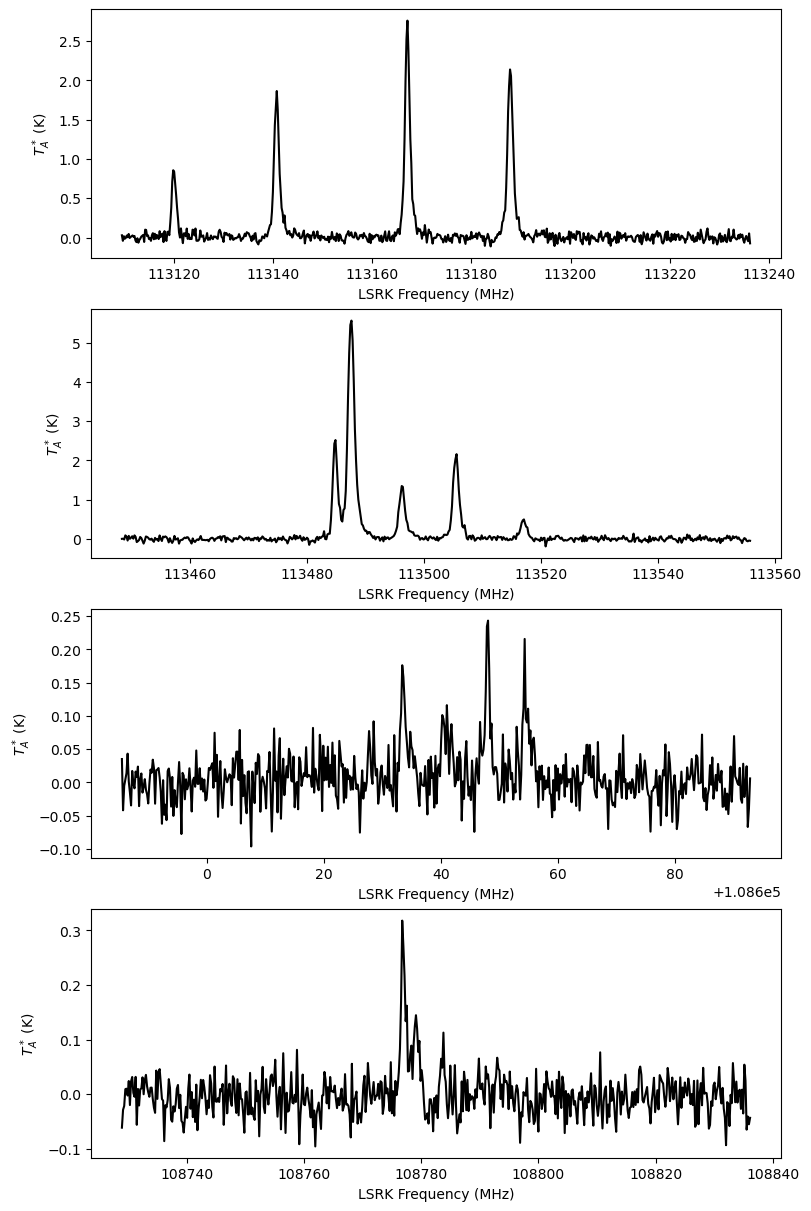

In [14]:
from bayes_spec import SpecData
import pickle

with open("iram_data.pkl", "rb") as f:
    iram_data = pickle.load(f)

labels = ["12CN-1/2", "12CN-3/2", "13CN-1/2", "13CN-3/2"]
data = {
    label: SpecData(
        iram_data[f"frequency_{label}"][500:-500],
        iram_data[f"spectrum_{label}"][500:-500],
        iram_data[f"rms_{label}"],
        xlabel=r"LSRK Frequency (MHz)",
        ylabel=r"$T_A^*$ (K)",
    )
    for label in labels
}
data_12CN = {
    label: SpecData(
        iram_data[f"frequency_{label}"][500:-500],
        iram_data[f"spectrum_{label}"][500:-500],
        iram_data[f"rms_{label}"],
        xlabel=r"LSRK Frequency (MHz)",
        ylabel=r"$T_A^*$ (K)",
    )
    for label in labels if "12CN" in label
}
for label, dataset in data.items():
    print(label, len(dataset.spectral))

# Plot the data
fig, axes = plt.subplots(4, layout="constrained", figsize=(8, 12))
for i, label in enumerate(labels):
    axes[i].plot(data[label].spectral, data[label].brightness, 'k-')
    axes[i].set_xlabel(data[label].xlabel)
    axes[i].set_ylabel(data[label].ylabel)

## Assess LTE and Optical Depth
First we explore the CN data to see if we can constrain the optical depth and non-LTE effects. These data do not have sufficient spectral resolution to constrain the thermal line width, and we expect there to be non-thermal broadening. We therefore fix the kinetic temperature. Hyperfine anomalies also appear to be present.

In [40]:
from bayes_cn_hfs import HFSAnomalyModel

# Initialize and define the model
n_clouds = 1
baseline_degree = 0
model = HFSAnomalyModel(
    data_12CN,
    mol_weight=weight_12CN, # molecular weight
    mol_data=mol_data_12CN, # molecular data
    bg_temp = 2.7, # assumed background temperature (K)
    Beff=0.78, # Main beam efficiency
    Feff=0.94, # Forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_tau_total = 1.0, # width of total optical depth prior
    prior_velocity = [10.0, 10.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 0.1, # width of non-thermal FWHM prior (km/s)
    prior_log10_anomaly = 0.1, # width of hyperfine anomaly prior (dex)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s)
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # default baseline priors
    fix_tau_total = None, # do not assume tau_total
    fix_log10_Tkin = 1.5, # assume Tkin
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

Sampling: [12CN-1/2, 12CN-3/2, baseline_12CN-1/2_norm, baseline_12CN-3/2_norm, fwhm_L_norm, fwhm_nonthermal_norm, log10_anomaly_norm, tau_total_norm, velocity_norm]


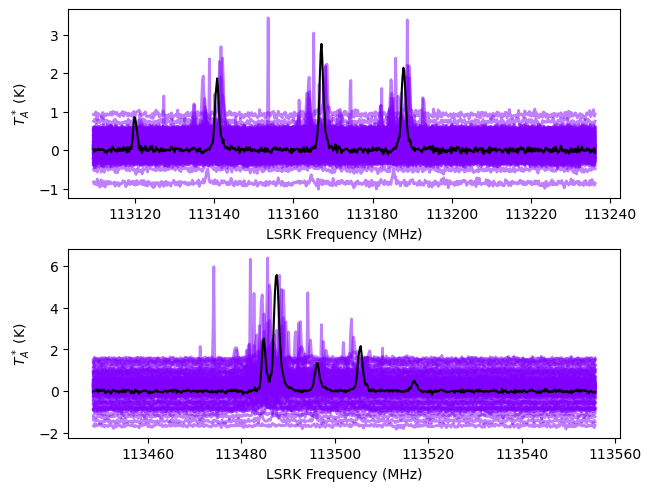

In [41]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

In [42]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.1, # VI absolute convergence threshold
    learning_rate = 1e-2, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 3600
Interrupted at 3,599 [3%]: Average Loss = 11,874


Output()

Runtime: 0.61 minutes


In [43]:
pm.summary(model.trace.posterior)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
baseline_12CN-1/2_norm[0],-0.301,0.007,-0.314,-0.288,0.000,0.000,950.0,722.0,NaN
baseline_12CN-3/2_norm[0],-0.297,0.005,-0.306,-0.289,0.000,0.000,1045.0,781.0,NaN
velocity_norm[0],-0.083,0.001,-0.085,-0.081,0.000,0.000,956.0,992.0,NaN
"log10_anomaly_norm[113123.3687, 0]",6.406,0.142,6.133,6.668,0.004,0.003,1022.0,1016.0,NaN
"log10_anomaly_norm[113144.19, 0]",1.143,0.056,1.045,1.255,0.002,0.001,762.0,847.0,NaN
"log10_anomaly_norm[113170.535, 0]",2.755,0.041,2.678,2.830,0.001,0.001,985.0,805.0,NaN
"log10_anomaly_norm[113191.325, 0]",1.021,0.044,0.946,1.107,0.001,0.001,1032.0,844.0,NaN
"log10_anomaly_norm[113488.142, 0]",0.435,0.063,0.314,0.549,0.002,0.001,1173.0,896.0,NaN
"log10_anomaly_norm[113490.985, 0]",1.130,0.025,1.082,1.177,0.001,0.001,1019.0,1013.0,NaN
"log10_anomaly_norm[113499.643, 0]",-0.134,0.081,-0.278,0.027,0.003,0.002,845.0,1026.0,NaN


Sampling: [12CN-1/2, 12CN-3/2]


Output()

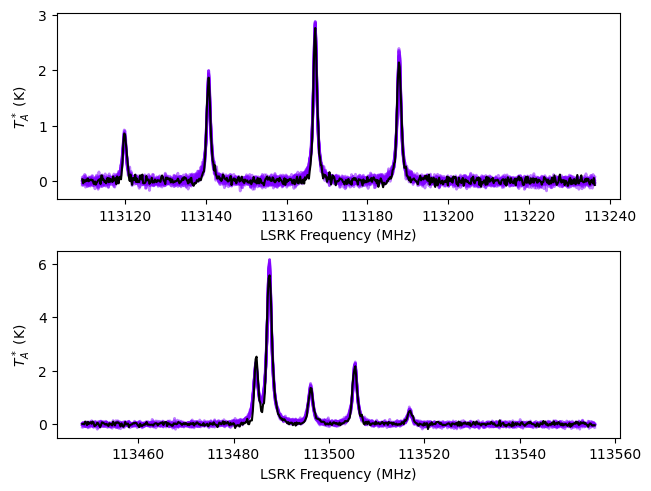

In [44]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

In [45]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 1e-2}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 3600
Interrupted at 3,599 [3%]: Average Loss = 11,874
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1/2_norm, baseline_12CN-3/2_norm, tau_total_norm, velocity_norm, fwhm_nonthermal_norm, fwhm_L_norm, log10_anomaly_norm]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 530 seconds.


Adding log-likelihood to trace


Output()

Runtime: 9.78 minutes


In [46]:
pm.summary(model.trace.posterior)

/opt/conda/envs/bayes_cn_hfs-dev/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
baseline_12CN-1/2_norm[0],-0.286,0.006,-0.298,-0.274,0.000,0.000,7141.0,4732.0,1.00
baseline_12CN-3/2_norm[0],-0.290,0.004,-0.298,-0.282,0.000,0.000,6736.0,5151.0,1.00
velocity_norm[0],-0.087,0.001,-0.088,-0.085,0.000,0.000,7443.0,5229.0,1.00
"log10_anomaly_norm[113123.3687, 0]",4.305,0.303,3.703,4.843,0.008,0.005,1605.0,2225.0,1.01
"log10_anomaly_norm[113144.19, 0]",-0.736,0.252,-1.209,-0.263,0.007,0.005,1421.0,1992.0,1.01
"log10_anomaly_norm[113170.535, 0]",0.817,0.262,0.315,1.293,0.007,0.005,1398.0,1853.0,1.01
"log10_anomaly_norm[113191.325, 0]",-0.838,0.247,-1.300,-0.375,0.007,0.005,1377.0,1782.0,1.01
"log10_anomaly_norm[113488.142, 0]",-1.247,0.246,-1.682,-0.762,0.007,0.005,1361.0,1905.0,1.01
"log10_anomaly_norm[113490.985, 0]",-0.592,0.226,-1.021,-0.172,0.006,0.004,1329.0,1780.0,1.01
"log10_anomaly_norm[113499.643, 0]",-1.931,0.245,-2.378,-1.459,0.007,0.005,1379.0,1962.0,1.01


Sampling: [12CN-1/2, 12CN-3/2]


Output()

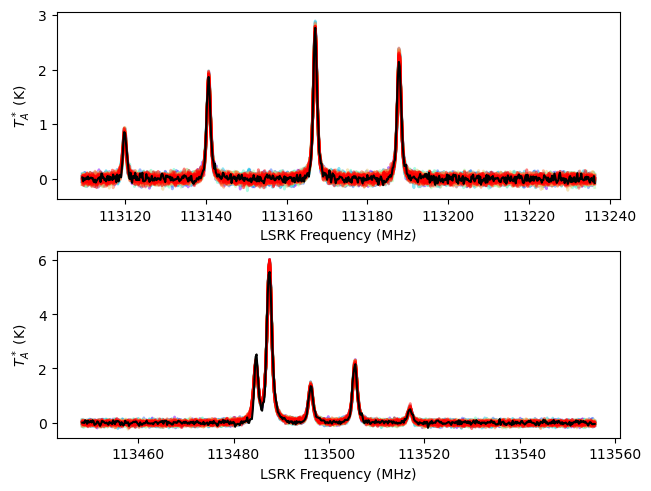

In [47]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

## Determine Number of Clouds

The CN data has much greater signal-to-noise, so let's use those data to constrain the number of "cloud" components. We suspect that non-thermal broadening is important and we do not have sufficient spectral resolution to resolve the thermal line widths. We also suspect that hyperfine anomalies impact the CN data, so we use `HFSAnomalyModel`. For this degenerate model, we can't constrain the optical depth or kinetic temperature, so we assume the emission is optically thin.

In [48]:
from bayes_cn_hfs import get_molecule_data

mol_data_12CN = get_molecule_data(
    "CN, v = 0, 1", # molecule name in JPLSpec
    vibrational_state = 0, # vibrational state number
    rot_state_lower = 0, # lower rotational state
)
weight_12CN = 12.0 + 14.0

In [58]:
from bayes_cn_hfs import HFSAnomalyModel
from bayes_spec import Optimize

max_n_clouds = 5
baseline_degree = 0
opt = Optimize(
    HFSAnomalyModel,
    data_12CN,
    mol_weight=weight_12CN, # molecular weight
    mol_data=mol_data_12CN, # molecular data
    bg_temp = 2.7, # assumed background temperature (K)
    Beff = 1.0, # beam efficiency
    Feff = 1.0, # forward efficiency
    max_n_clouds=max_n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
opt.add_priors(
    prior_velocity = [10.0, 5.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal FWHM prior (km/s)
    prior_log10_anomaly = 0.1, # width of hyperfine anomaly prior (dex)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s)
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # default baseline priors
    fix_tau_total = 0.1, # fix tau_total
    fix_log10_Tkin = 1.5, # fix log10_Tkin
    ordered = False, # do not assume optically-thin
)
opt.add_likelihood()

In [59]:
fit_kwargs = {
    "rel_tolerance": 0.01,
    "abs_tolerance": 0.1,
    "learning_rate": 1e-2,
}
opt.fit_all(**fit_kwargs)

Null hypothesis BIC = 9.570e+04
Approximating n_cloud = 1 posterior...


Output()

Convergence achieved at 7200
Interrupted at 7,199 [7%]: Average Loss = 21,447


Output()

n_cloud = 1 BIC = -1.420e+02

Approximating n_cloud = 2 posterior...


Output()

Convergence achieved at 17700
Interrupted at 17,699 [17%]: Average Loss = 6,567.7


Output()

n_cloud = 2 BIC = -2.684e+03

Approximating n_cloud = 3 posterior...


Output()

Convergence achieved at 15000
Interrupted at 14,999 [14%]: Average Loss = 6,238.7


Output()

n_cloud = 3 BIC = -2.757e+03

Approximating n_cloud = 4 posterior...


Output()

Convergence achieved at 28300
Interrupted at 28,299 [28%]: Average Loss = 2,666.2


Output()

n_cloud = 4 BIC = -2.988e+03

Approximating n_cloud = 5 posterior...


Output()

Convergence achieved at 31500
Interrupted at 31,499 [31%]: Average Loss = 2,062.4


Output()

n_cloud = 5 BIC = -2.999e+03



In [60]:
n_clouds = np.arange(max_n_clouds + 1)
null_bic = opt.models[1].null_bic()
bics_vi = np.array([null_bic] + [model.bic(chain=0) for model in opt.models.values()])
for n_cloud, bic in zip(n_clouds, bics_vi):
    print(n_cloud, bic)

0 95704.84851857378
1 -141.99916911614653
2 -2683.865918461791
3 -2756.788168882774
4 -2988.2105955864604
5 -2999.2679364407904


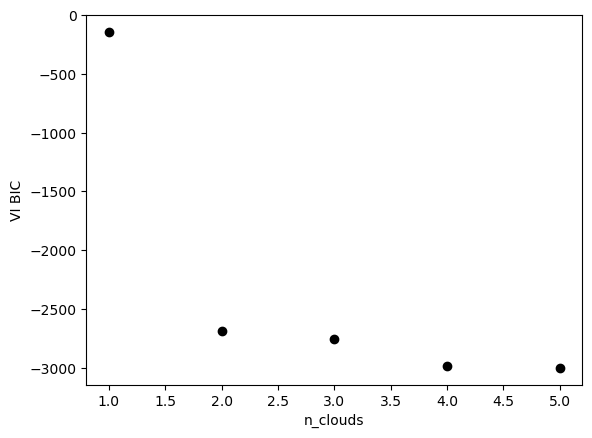

In [61]:
fig, ax = plt.subplots()
ax.plot(n_clouds[1:], bics_vi[1:], 'ko')
ax.set_xlabel("n_clouds")
_ = ax.set_ylabel("VI BIC")

The model with `n_clouds = 3` seems to be best. Let's compare with MCMC.

In [ ]:
fit_kwargs = {
    "rel_tolerance": 0.01,
    "abs_tolerance": 0.1,
    "learning_rate": 1e-2,
}
sample_kwargs = {
    "chains": 8,
    "cores": 8,
    "init_kwargs": fit_kwargs,
    "nuts_kwargs": {"target_accept": 0.8},
}
opt.optimize(fit_kwargs=fit_kwargs, sample_kwargs=sample_kwargs, approx=False)

Null hypothesis BIC = 9.570e+04
Sampling n_cloud = 1 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 7200
Interrupted at 7,199 [7%]: Average Loss = 21,447
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1/2_norm, baseline_12CN-3/2_norm, velocity_norm, fwhm_nonthermal_norm, fwhm_L_norm, log10_anomaly_norm]


Output()

In [ ]:
null_bic_mcmc = opt.models[1].null_bic()
bics_mcmc = np.array([null_bic_mcmc] + [model.bic() for model in opt.models.values()])
for n_cloud, bic in zip(n_clouds, bics_mcmc):
    print(n_cloud, bic)

In [ ]:
fig, ax = plt.subplots()
ax.plot(n_clouds[1:], bics_vi[1:], 'ko', label="VI")
ax.plot(n_clouds[1:], bics_mcmc[1:], 'ro', label="MCMC")
ax.set_xlabel("n_clouds")
ax.legend(loc="best")
_ = ax.set_ylabel("BIC")

In [ ]:
from bayes_spec.plots import plot_predictive

posterior = opt.best_model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(opt.best_model.data, posterior.posterior_predictive)

In [12]:
print(f"Best model has n_clouds={opt.best_model.n_clouds}")
print(f"Best model has solutions={opt.best_model.solutions}")
pm.summary(opt.best_model.trace.solution_0)

Best model has n_clouds=3
Best model has solutions=[0, 1]


/opt/conda/envs/bayes_cn_hfs-dev/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
baseline_12CN-1/2_norm[0],-0.153,0.006,-0.164,-0.142,0.001,0.001,37.0,71.0,1.04
baseline_12CN-3/2_norm[0],-0.151,0.005,-0.161,-0.143,0.001,0.001,36.0,14.0,1.04
velocity_norm[0],3.309,0.024,3.267,3.349,0.002,0.002,106.0,328.0,1.03
velocity_norm[1],2.854,0.026,2.803,2.900,0.001,0.001,346.0,527.0,1.00
velocity_norm[2],2.925,0.011,2.907,2.947,0.002,0.001,50.0,156.0,1.03
"log10_anomaly_norm[113123.3687, 0]",3.339,0.931,1.435,4.972,0.042,0.030,493.0,1054.0,1.02
"log10_anomaly_norm[113123.3687, 1]",1.312,1.134,-0.786,3.361,0.123,0.087,89.0,459.0,1.02
"log10_anomaly_norm[113123.3687, 2]",9.839,0.290,9.345,10.417,0.027,0.019,111.0,127.0,1.02
"log10_anomaly_norm[113144.19, 0]",1.345,0.367,0.710,2.044,0.023,0.016,249.0,493.0,1.03
"log10_anomaly_norm[113144.19, 1]",2.356,0.379,1.689,3.021,0.071,0.051,32.0,147.0,1.05


## MCMC

In [ ]:
from bayes_cn_hfs import CNRatioAnomalyIRAMModel

# Initialize and define the model
n_clouds = 3
baseline_degree = 0
model = CNRatioAnomalyIRAMModel(
    data,
    bg_temp = 2.7, # assumed background temperature (K)
    Beff=0.78, # Main beam efficiency
    Feff=0.94, # Forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N_12CN = [14.0, 1.0], # mean and width of log10(12CN N) prior (cm-2)
    prior_log10_tex = [1.0, 0.1], # mean and width of log10(Tex) prior (K)
    prior_fwhm = 1.0, # width of FWHM prior (km/s)
    prior_velocity = [10.0, 10.0], # mean and width of velocity prior (km/s)
    prior_ratio_13C_12C = 0.01, # width of the 13C/12C prior
    prior_log10_tex_12CN_anomaly = 0.1, # width of 12CN Tex anomaly (K)
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

In [ ]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

In [ ]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 1e-2}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.9}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")